<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers
from keras import callbacks

In [38]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [39]:
# x_train = x_train.reshape(60000, 784).astype('float32') / 255
# x_test = x_test.reshape(10000, 784).astype('float32') / 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Перемешаем тренировочные данные
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [40]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [41]:
model = tf.keras.Sequential()

drop_out = 0.4
lern_rat = 0.001
neurons = 32

model.add(layers.Flatten(input_shape=(28, 28)))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(lern_rat)))
# model.add(layers.Dropout(drop_out))
model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(lern_rat)))
# model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(lern_rat)))
# model.add(layers.Dropout(drop_out))
model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(lern_rat)))
# model.add(layers.Dropout(drop_out))
# model.add(layers.Dense(neurons, activation='tanh', kernel_regularizer=regularizers.l2(lern_rat)))
# model.add(layers.Dropout(drop_out))

model.add(layers.Dense(10, activation='softmax'))
# model.add(layers.Softmax())

In [42]:
model.compile(#optimizer='adam',
              optimizer='adamax',
              # optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [43]:
callback = callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [44]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(x_train, y_train,
                    epochs=120,
                    batch_size=32,
                    callbacks=[callback],
                    validation_data=(x_val, y_val))
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/120
1563/1563 [==============================] - 8s 4ms/step - loss: 0.8557 - sparse_categorical_accuracy: 0.7438 - val_loss: 0.6569 - val_sparse_categorical_accuracy: 0.8075
Epoch 2/120
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6108 - sparse_categorical_accuracy: 0.8272 - val_loss: 0.6081 - val_sparse_categorical_accuracy: 0.8244
Epoch 3/120
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5614 - sparse_categorical_accuracy: 0.8445 - val_loss: 0.5550 - val_sparse_categorical_accuracy: 0.8470
Epoch 4/120
1563/1563 [==============================] - 7s 4ms/step - loss: 0.5334 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.5665 - val_sparse_categorical_accuracy: 0.8404
Epoch 5/120
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5120 - sparse_categorical_accuracy: 0.8584 - val_loss: 0.5110 - val_sparse_categorical_accuracy: 0.8600
Epoch 6/120
1563/1563 [==============================] - 7s 4ms/step - loss: 0.4946 -

In [45]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']


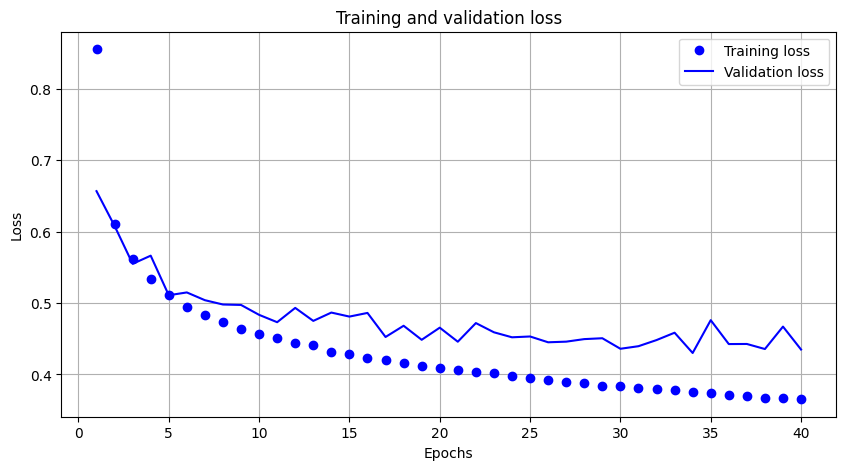

<Figure size 640x480 with 0 Axes>

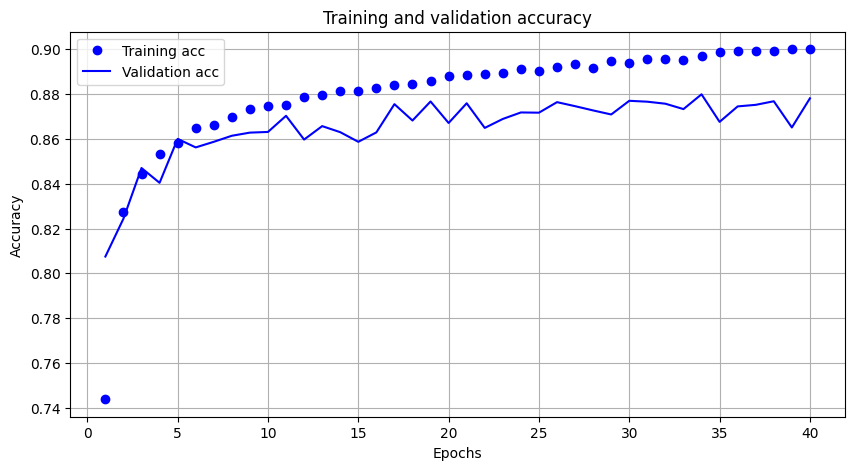

In [46]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [47]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [48]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [49]:
predictions[0]

array([0.08641808, 0.08611678, 0.08611331, 0.08614218, 0.08611193,
       0.0880391 , 0.08634616, 0.08888903, 0.08648391, 0.21933953],
      dtype=float32)

In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 32)                25120     
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 32)                1056      
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 10)                330       
                                                                 
Total params: 28618 (111.79 KB)
Trainable params: 2861